In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd', ticks=True, grid=True, figsize=(12, 6), fscale=1.4)
%matplotlib inline

# Introduction to Dynamical Systems Modeling with PyRates


<p style="text-align: center;">presented by Richard Gast </p>


Kennedy lab meeting, 09/23/2022

## Overview: Dynamical Systems (DS) Modeling

- describe evolution of system over time (continuous or discrete time)

- continuous-time systems are defined via differential equation (DE) systems:

$$\dot y = f(y, \theta, t)$$

- we are interested in the solutions to these DE systems $y(t) = \int f(y, \theta, t) dt$ and how they depend on the system parameters $\theta$

- Numerical methods exist, for example, for:
    - finding $y(t)$ given a particular choice for $\theta$
    - estimating how $y(t)$ changes for small changes in $\theta$
    - optimizing $\theta$ in order to generate a target solution $y(t)$

### DS modeling: Neuroscience applications

Can be applied to any scale of brain organization or function:

- DEs for modeling ion channel dynamics in part of the membrane: Hodgkin-Huxley equations (1952-55)

- DEs for firing of a single neuron: Ermentrout-Kopell equations (1986)

- DEs for firing rate dynamics of a neural population: Montbrio et al. (2015) 

- DEs for dynamics of a cortical column/brain region: Jansen and Rit (1995), Wilson and Cowan (1972)

- DEs for action kinetics and motor program selection: Haken (1976)

- DEs for decision making processes: Busemeyer and Johnson (2004)
- ...

### DS modeling (example): RNN of leaky-integrator rate neurons

Evolution equations for $N$ coupled rate neurons:
$$ \dot u_i = -\frac{u_i}{\tau} + I_{ext}(t) + k \sum_{j=1}^{N} J_{ij} \tanh (u_j)$$

Variables:
- $u_i$: state variable of neuron $i$
- $\tau$: global rate decay time constant
- $I_{ext}$: Extrinsic input/forcing signal
- $k$: global coupling constant
- $J_{ij}$: Pairwise coupling strengths
- $N$: number of rate neurons

### DS modeling (example): Simulations via PyRates/RectiPy

In [2]:
from rectipy import Network

# parameters
node = "neuron_model_templates.rate_neurons.leaky_integrator.tanh_pop"
N = 5
J = np.random.randn(N, N)
k = 1.5
tau = 0.5

# model initialization
net0 = Network.from_yaml(node=node, weights=J, source_var="tanh_op/r", target_var="li_op/r_in", 
                         input_var="li_op/I_ext", output_var="li_op/u", clear=True,
                         node_vars={"all/li_op/k": k, "all/li_op/tau": tau})



Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


In [3]:
# define input
steps = 10000
dt = 1e-3
target_neuron = 1
time = np.arange(0, steps)*dt
I_ext = np.zeros((steps, N))
I_ext[:, target_neuron] = np.sin(np.pi*time) * 0.5

# run simulation
obs = net0.run(inputs=I_ext, verbose=False)

<AxesSubplot:xlabel='time', ylabel='out'>

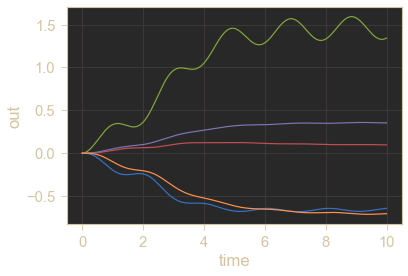

In [4]:
# plotting
obs.plot("out")

## PyRates: A Python tool for DS modeling

<img src="img/pyrates_structure.png" width="700">

### PyRates: Installation

Recommended: Use dedicated Python environment
```
conda create -n ds python=3.9
```

Installation via pip:
```
pip install pyrates
```

Dependencies:
- numpy
- networkx
- pandas
- ruamel.yaml
- sympy
- scipy

For full backend support:
- tensorflow
- torch

### PyRates: Model definition



- hierarchical, graph-based
- two frontend interfaces: YAML or pure Python
- detailed introductions to the model definition on [readthedocs](https://pyrates.readthedocs.io/en/latest/) for the [YAML](https://pyrates.readthedocs.io/en/latest/auto_implementations/yaml_definitions.html#sphx-glr-auto-implementations-yaml-definitions-py) and [Python](https://pyrates.readthedocs.io/en/latest/auto_implementations/python_definitions.html#sphx-glr-auto-implementations-python-definitions-py) interface

**Implementation of the rate neuron model via the Python interface**

*Step 1:* Define mathematical operators

In [5]:

from pyrates import OperatorTemplate

# leaky integration operator
equation = "u' = -u/tau + k*r_in + I_ext"
variables = {"u": "output(0.0)", "tau": tau, "k": k, "r_in": "input", "I_ext": "input"}
li_op = OperatorTemplate("li_op", equations=equation, variables=variables)

# hyperbolic tangent transform
equation = "r = tanh(u)"
variables = {"r": "output(0.0)", "u": "input"}
tanh_op = OperatorTemplate("tanh_op", equations=equation, variables=variables)

*Step 2:* Connect operators to define nodes 

In [6]:
from pyrates import NodeTemplate
node = NodeTemplate("rate_neuron", operators=[li_op, tanh_op])

*Step 3:* Connect nodes to define a circuit

In [7]:
from pyrates import CircuitTemplate

# initialize network with unconnected nodes
nodes = [f"n_{i}" for i in range(N)]
net = CircuitTemplate("net", nodes={n: node for n in nodes})

# add edges between nodes
net.add_edges_from_matrix(source_var="tanh_op/r", target_var="li_op/r_in", 
                          nodes=nodes, weight=J)

### PyRates: Applications

- translates model equations into compute graph
- uses code-generation to generate functions that allow to evaluate the vector-field of a given model, i.e. $\dot y = f(y,\theta,t)$.
- vector-field evaluation functions generated by *PyRates* provide interface to various dynamical systems optimization/analysis tools


## Example 1: Parameter sweep

We perform a parameter sweep over global coupling constant $k$ and global decay time constant $\tau$

In [8]:
from pyrates import grid_search

# define sweep
ks = np.asarray([0.25, 0.5, 1.0, 2.0, 4.0])
taus = np.asarray([0.25, 0.5, 1.0, 2.0, 4.0])
param_map = {"k": {"vars": ["li_op/k"], "nodes": nodes}, 
             "tau": {"vars": ["li_op/tau"], "nodes": nodes}}

# perform sweep
T = 10.0
dt = 1e-3
res, mapping = grid_search(
    net, param_grid={"k": ks, "tau": taus}, param_map=param_map, permute_grid=True,
    simulation_time=T, step_size=dt, solver="scipy", method="RK45",
    outputs={"u": "all/li_op/u"}, inputs={f"n_{target_neuron}/li_op/I_ext": I_ext[:, target_neuron]}
)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.0469859000000028s.


C:\Users\rgf3807\.conda\envs\ds\lib\site-packages\scipy-1.8.0rc2-py3.9-win-amd64.egg\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `vectorization`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [9]:
res["u"]["net_0"]

,n_0,n_1,n_2,n_3,n_4
,li_op/u,li_op/u,li_op/u,li_op/u,li_op/u
0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.001,-1.226824e-10,7.843181e-07,8.306202e-12,3.382021e-11,-1.496392e-11
0.002,-9.797151e-10,3.133272e-06,6.634147e-11,2.700656e-10,-1.195530e-10
0.003,-3.299820e-09,7.040864e-06,2.234928e-10,9.095466e-10,-4.029220e-10
0.004,-7.805642e-09,1.250111e-05,5.287771e-10,2.151331e-09,-9.537139e-10
...,...,...,...,...,...
9.995,8.848886e-03,-6.607811e-02,-6.875683e-04,-2.313167e-03,1.545971e-03
9.996,8.842778e-03,-6.583733e-02,-6.873051e-04,-2.311339e-03,1.545925e-03
9.997,8.836583e-03,-6.559590e-02,-6.870352e-04,-2.309489e-03,1.545863e-03


In [21]:
mapping

,k,tau
net_0,0.25,0.25
net_1,0.50,0.25
net_2,1.00,0.25
net_3,2.00,0.25
net_4,4.00,0.25
net_5,0.25,0.50
net_6,0.50,0.50
net_7,1.00,0.50
net_8,2.00,0.50
net_9,4.00,0.50


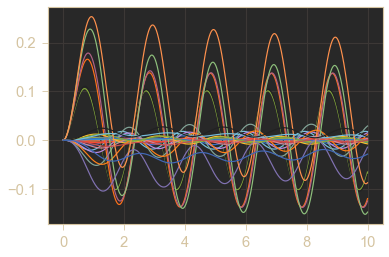

In [11]:
idx = (mapping["k"] - 0.5 < 0.1) & (mapping["tau"] - 1.0 < 0.1)
_ = plt.plot(res["u"][mapping.index[idx]])

### Example 1: Results

In [12]:
import sys
sys.path.insert(0, "../signal_processing_and_visualization")
from visualization import Interactive2DParamPlot
from pandas import DataFrame

In [13]:
C = np.zeros((len(ks), len(taus)))
for col, tau in enumerate(taus):
    for row, k in enumerate(ks):
        idx = (mapping["k"] - k < 0.1) & (mapping["tau"] - tau < 0.1)
        data = res["u"][mapping.index[idx]]
        v = np.std(data, axis=0)
        C[row, col] = np.mean(v[:])

<IPython.core.display.Javascript object>


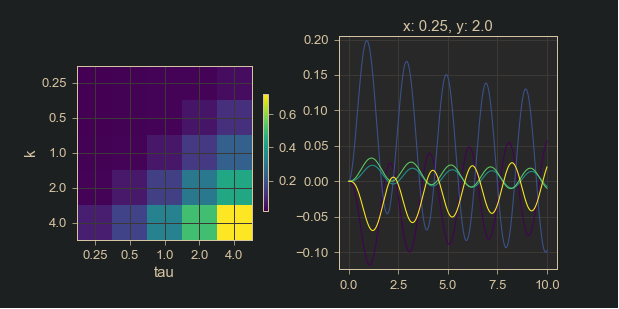

C:\Users\rgf3807\PycharmProjects\use_examples\../signal_processing_and_visualization\visualization.py:879: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax[0].set_xticklabels([""] + list(np.round(x_values, decimals=2)))
C:\Users\rgf3807\PycharmProjects\use_examples\../signal_processing_and_visualization\visualization.py:880: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax[0].set_yticklabels([""] + list(np.round(y_values, decimals=2)))


In [23]:
%matplotlib notebook
Interactive2DParamPlot(C, res["u"], taus, ks, "tau", "k", mapping, cmap_lines="viridis")

## Example 2: Parameter optimization

We will perform automated optimization of $k$ and $\tau$ via *RectiPy*. 

In [34]:
k_t = np.random.uniform(0.25, 4.0)
tau_t = np.random.uniform(0.25, 4.0)
k_0 = np.random.uniform(0.25, 4.0)
tau_0 = np.random.uniform(0.25, 4.0)

# target model initialization
tnet = Network.from_yaml(node=node, weights=J, source_var="tanh_op/r", target_var="li_op/r_in", 
                         input_var="li_op/I_ext", output_var="li_op/u", clear=True,
                         node_vars={"all/li_op/k": k_t, "all/li_op/tau": tau_t})
tnet.compile()

# test model initialization
lnet = Network.from_yaml(node=node, weights=J, source_var="tanh_op/r", target_var="li_op/r_in", 
                         input_var="li_op/I_ext", output_var="li_op/u", clear=True,
                         node_vars={"all/li_op/k": k_0, "all/li_op/tau": tau_0},
                         train_params=["li_op/k", "li_op/tau"])
lnet.compile()
print(list(tnet.parameters()))
print(list(lnet.parameters()))

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
[]
[tensor([0.3122], dtype=torch.float64, requires_grad=True), tensor([0.3873], dtype=torch.float64, requires_grad=True)]


<IPython.core.display.Javascript object>


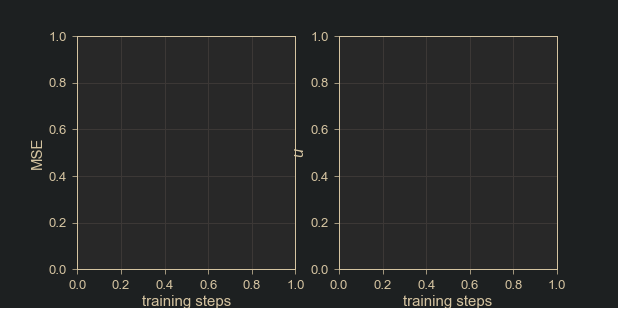

Text(0, 0.5, '$u$')

In [35]:
fig, ax = plt.subplots(ncols=2)
ax[0].set_xlabel("training steps")
ax[0].set_ylabel("MSE")
ax[1].set_xlabel("training steps")
ax[1].set_ylabel(r"$u$")

In [36]:
# model fitting
opt = torch.optim.Rprop(lnet.parameters(), lr=0.01, etas=(0.5, 1.1), step_sizes=(1e-5, 1e-1))
loss = torch.nn.MSELoss()
error, tol, step, update_steps, plot_steps = 1.0, 1e-4, 0, 1000, 100
mse_col, target_col, prediction_col = [], [], []
while error > tol:
    
    # calculate forwards
    I_ext = np.sin(np.pi*step*dt)*0.5
    target = tnet.forward(I_ext)
    prediction = lnet.forward(I_ext)
    step += 1
    
    # calculate loss and make optimization step
    l = loss(target, prediction)
    l.backward(retain_graph=True)
    if step % update_steps == 0:
        opt.step()
        opt.zero_grad()
    error = 0.9*error + 0.1*l.item()
    
    # plotting
    mse_col.append(error)
    target_col.append(target.detach().numpy()[0])
    prediction_col.append(prediction.detach().numpy()[0])
    if step % plot_steps == 0:
        ax[0].plot(mse_col, "red")
        ax[1].plot(target_col, "blue")
        ax[1].plot(prediction_col, "orange")
        fig.canvas.draw()
        fig.canvas.flush_events()

In [37]:
params = list(lnet.parameters())
k = params[0].clone().detach().numpy()
tau = params[1].clone().detach().numpy()

print("Target parameters: " + r"$k_t$ = " + f"{k_t}" + r", $\tau_t$ = " + f"{tau_t}.")
print("Starting parameters: " + r"$k_0$ = " + f"{k_0}" + r", $\tau_0$ = " + f"{tau_0}.")
print("Optimized parameters: " + r"$k_*$ = " + f"{k[0]}" + r", $\tau_*$ = " + f"{tau[0]}.")

Target parameters: $k_t$ = 3.8566872940172137, $\tau_t$ = 2.560580558942296.
Starting parameters: $k_0$ = 0.3121732525425235, $\tau_0$ = 0.3873119418625199.
Optimized parameters: $k_*$ = 0.3121732525425235, $\tau_*$ = 0.3873119418625199.
